# Credit Fraud

This problem is to try and predict when a transaction is fraudulant

## 0. Preparations

### Import the libraries needed

In [ ]:
# Pip installs
!pip install category_encoders==2.*

# Import Libraries

import glob

# For model building
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning

# For encoding categorical data
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder

# Datetime manipulation
from datetime import datetime

# Libraries for data manipulation
import numpy as np
import pandas as pd

# Libraries for plotting visuals
import matplotlib.pyplot as plt

     |████████████████████████████████| 80 kB 3.9 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### API set up to download the data from Kaggle

In [ ]:
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
# Downloading and Unzip
!kaggle datasets download "saurabhbagchi/credit-card-fraud-detection";
!unzip credit-card-fraud-detection.zip;

 32% 9.00M/28.1M [00:00<00:00, 21.4MB/s]
100% 28.1M/28.1M [00:00<00:00, 52.1MB/s]
Archive:  credit-card-fraud-detection.zip
  inflating: simulated-data-raw-main/README.md  
  inflating: simulated-data-raw-main/data/2018-04-01.pkl  
  inflating: simulated-data-raw-main/data/2018-04-02.pkl  
  inflating: simulated-data-raw-main/data/2018-04-03.pkl  
  inflating: simulated-data-raw-main/data/2018-04-04.pkl  
  inflating: simulated-data-raw-main/data/2018-04-05.pkl  
  inflating: simulated-data-raw-main/data/2018-04-06.pkl  
  inflating: simulated-data-raw-main/data/2018-04-07.pkl  
  inflating: simulated-data-raw-main/data/2018-04-08.pkl  
  inflating: simulated-data-raw-main/data/2018-04-09.pkl  
  inflating: simulated-data-raw-main/data/2018-04-10.pkl  
  inflating: simulated-data-raw-main/data/2018-04-11.pkl  
  inflating: simulated-data-raw-main/data/2018-04-12.pkl  
  inflating: simulated-data-raw-main/data/2018-04-13.pkl  
  inflating: simulated-data-raw-main/data/2018-04-14.pkl  
 

## I. Wrangle Data

In [ ]:
def wrangle():
# Import
  path =r'simulated-data-raw-main/data'
  filenames = glob.glob(path + "/*.pkl")

  dfs = []
  for filename in filenames:
      dfs.append(pd.read_pickle(filename))

  # Concatenate all data into one DataFrame
  df = pd.concat(dfs, ignore_index=True)
# Sort
  df = df.sort_values(["CUSTOMER_ID", "TX_DATETIME"], ascending = (True, True)).reset_index(drop=True)

# Rename Columns
  df.columns = ['Transaction_id', 'Datetime', 'Customer_id', 'Terminal_id', 'Amount', 'Time_seconds', 'Time_days', 'Fraud', 'Fraud_scenario']

# Change dtypes of columns
  convert_dict = {'Time_seconds': int,'Time_days': int}
  df = df.astype(convert_dict)

# Create New Columns
  # Day of the Week (Mon, Tue, Wed, ... etc)
  df['Weekday'] = df['Datetime'].dt.day_name()

  # Amount of last transaction for customer
  df.loc[df['Customer_id'] == df['Customer_id'].shift(1),'Customer_last_transaction_amount'] = df['Amount'].shift(1)

  # Last Terminal 
  
  # Time since last transaction for customer
  df.loc[df['Customer_id'] == df['Customer_id'].shift(1),'Time_since_last_cust_transaction'] = round((df['Datetime']-df['Datetime'].shift(1)).dt.total_seconds()/3600,1)

# Drop columns with high number of NaN Values
  df.dropna(axis = 1,thresh = 300, inplace = True)

# Drop columns with HCCC
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
                if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

# Columns to drop to prevent leakage
  drop_cols = ['Fraud_scenario', 'Datetime']
  df = df.drop(columns = drop_cols)

# Balance out the target variable
  print('Baseline Accuracy:', df['Fraud'].value_counts(normalize=True).max())
  # # df_yes = all yes
  # df_yes = df.loc[df['Fraud'] == 1]

  # # df_no = all no
  # df_no = df.loc[df['Fraud'] == 0]

  # randomly pick 10000 yes's
  df_yes = df.loc[df['Fraud'] == 1].sample(10000,replace=True, random_state=35)

  # randomly pick 20000 no's
  df_no = df.loc[df['Fraud'] == 0].sample(20000, replace=False, random_state=35)

  # concat yes and no df together and replace over old df
  df = pd.concat([df_yes, df_no])

  return df

df = wrangle()
display(df.head())

Baseline Accuracy: 0.9916307281853656


,Transaction_id,Amount,Time_seconds,Time_days,Fraud,Weekday,Customer_last_transaction_amount,Time_since_last_cust_transaction
672878,42307,75.25,383957,4,1,Thursday,11.68,6.7
137424,621432,366.55,5588107,64,1,Monday,30.61,1.3
1058609,1293776,89.01,11651561,134,1,Monday,156.18,10.1
831429,1250861,36.05,11272778,130,1,Thursday,125.00,18.1
337493,390071,84.46,3505572,40,1,Friday,73.48,0.3


## II. Split Data

In [ ]:
# Separate FM and TV
target = 'Fraud'
y = df[target]
X = df.drop(columns = target)

# Split train-test data by random
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

# Split train-test data by random
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25)

print(f'Training shape {X_train.shape}\nTesting shape {X_test.shape}\nValidation shape{X_val.shape}')

Training shape (18000, 7)
Testing shape (6000, 7)
Validation shape(6000, 7)


## III. Establish Baseline

In [ ]:
print('Baseline Accuracy:', y.value_counts(normalize=True).max())

Baseline Accuracy: 0.6666666666666666


## IV. Build Model

- `LogisticRegression`

In [ ]:
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                        SimpleImputer(strategy='mean'),
                        StandardScaler(),
                        LogisticRegression());
model_lr.fit(X_train,y_train);

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


- `DecisionTreeClassifier`


In [ ]:
model_dt = make_pipeline(OneHotEncoder(use_cat_names=True),
                        SimpleImputer(strategy='mean'),
                        StandardScaler(),
                        DecisionTreeClassifier(random_state=42));
model_dt.fit(X_train,y_train);

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


- `RandomForestClassifier`

In [ ]:
model_rf = make_pipeline(OneHotEncoder(use_cat_names=True),
                        SimpleImputer(strategy='mean'),
                        StandardScaler(),
                        RandomForestClassifier(random_state=42,n_jobs=-1));
model_rf.fit(X_train,y_train);

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## V. Check Metrics

In [ ]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.7390555555555556
Validation Accuracy (LOGR): 0.7451666666666666


In [ ]:
print('Training accuracy (TREE):', model_dt.score(X_train,y_train))
print('Validation accuracy (TREE):', model_dt.score(X_val,y_val))

Training accuracy (TREE): 1.0
Validation accuracy (TREE): 0.7145


In [ ]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8243333333333334


# VII. Tune Model

- What are important hyperparameters for `RandomForestClassifier`?
  - `max_depth`: 5-35
  - `n_estimators` 25-100
  - imputation strategy

**`GridSearch`:** Very thourough, but it can take a long time.

Test out every single combination of hyperparameters that we provide it
**and** it's going to use cross-validation.

In [ ]:
clf = make_pipeline(OneHotEncoder(),
                    SimpleImputer(),
                    StandardScaler(),
                    RandomForestClassifier(random_state=42, n_jobs = -1))

param_grid = {'simpleimputer__strategy':['median','mean'], # 2 possible values
             'randomforestclassifier__max_depth':range(5,35,5), # 6 possible values
             'randomforestclassifier__n_estimators':range(10,100,10)} # 9 possible values

model_rfgs = GridSearchCV(clf,
                         param_grid = param_grid,
                         n_jobs=-1,
                         cv = 5,
                         verbose = 1)

model_rfgs.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.8min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('onehotencoder',
                                        OneHotEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                                                      use_cat_names=False,
                                                      verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
           

In [ ]:
print('The best params:', model_rfgs.best_params_)
print('The best accuracy score for the grid search is:', model_rfgs.best_score_)
print('The accuracy score with the validation set:', model_rfgs.score(X_val,y_val))

The best params: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 90, 'simpleimputer__strategy': 'mean'}
The best accuracy score for the grid search is: 0.805111111111111
The accuracy score with the validation set: 0.8238333333333333


**`RandomizedSearchCV`:** Quicker, less effective but usually good enough.

In [ ]:
model_rfrs = RandomizedSearchCV(clf, 
                               param_distributions = param_grid,
                               n_iter = 15,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 1)
model_rfrs.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   58.7s finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=False,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
 

In [ ]:
print('The best params:', model_rfrs.best_params_)
print('The best accuracy score for the random search is:', model_rfrs.best_score_)
print('The accuracy score with the validation set:', model_rfrs.score(X_val,y_val))


The best params: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 90, 'randomforestclassifier__max_depth': 30}
The best accuracy score for the random search is: 0.805111111111111
The accuracy score with the validation set: 0.8238333333333333


In [ ]:
print('The accuracy score with the test set:', model_rfrs.score(X_test,y_test))

The accuracy score with the test set: 0.8176666666666667


## VI. Importance

### Logistic Regression

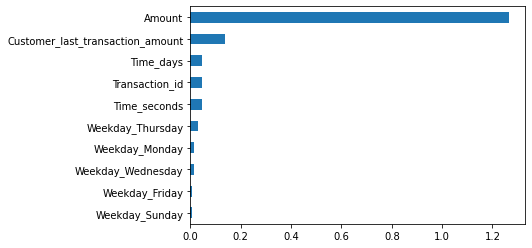

In [ ]:
feature_importance = abs(pd.Series(model_lr['logisticregression'].coef_[0], index = model_lr['onehotencoder'].get_feature_names())).sort_values()
feature_importance.tail(10).plot(kind = 'barh')
plt.show()

### Decision Tree

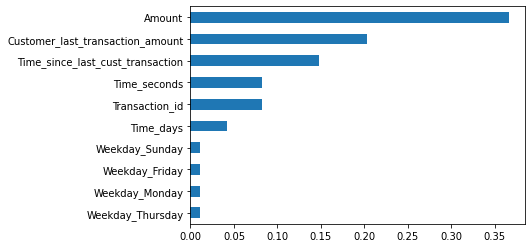

In [ ]:
features = model_dt.named_steps['onehotencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini,index=features).sort_values(key=abs).tail(10).plot(kind='barh')

### Random Forest

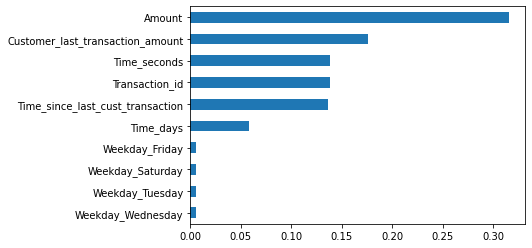

In [ ]:
importance = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = model_rf.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importance,index=features).sort_values(key=abs).tail(10).plot(kind='barh')

### Random Forest Grid Search

['Transaction_id', 'Amount', 'Time_seconds', 'Time_days', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Friday', 'Weekday_Thursday', 'Weekday_Sunday', 'Weekday_Monday', 'Weekday_Saturday', 'Customer_last_transaction_amount', 'Time_since_last_cust_transaction'] [0.13616302 0.3299881  0.13530957 0.057518   0.00523935 0.00520329
 0.00509226 0.00437742 0.0051055  0.00496492 0.00563143 0.17258882
 0.13281829]


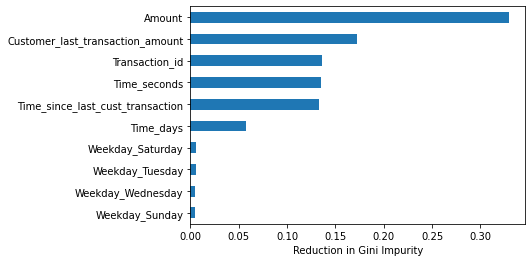

In [ ]:
best_estimator = model_rfgs.best_estimator_
importances = best_estimator.named_steps['randomforestclassifier'].feature_importances_
features = model_rf.named_steps['onehotencoder'].get_feature_names()
print(features,importances)
feat_imp = pd.Series(importances, index=features).sort_values(key=abs).tail(10)
feat_imp.plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

### Random Forest Random Estimator

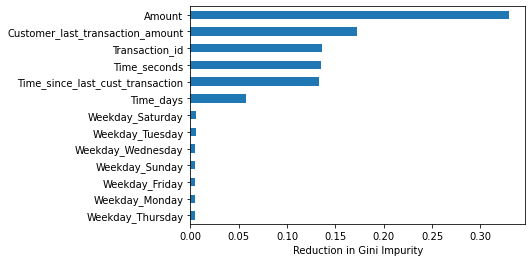

In [ ]:
best_estimator = model_rfrs.best_estimator_
importances = best_estimator.named_steps['randomforestclassifier'].feature_importances_
features = model_rf.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values(key=abs).tail(15)
feat_imp.plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

# How to save a trained model to reuse it in the future

In [ ]:
# #save model
# import pickle
# filename = 'accuracy_80perc'
# pickle.dump(model_rf,open(filename,'wb'))

# #load model
# model_rf = pickle.load(open(filename,'rb'))